# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## PaleoSTeHM background

[PaleoSTeHM](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2148265&HistoricalAwards=false) is a NSF funded project under award 2002437 and 2148265, aiming to develop a framework for for spatiotemporal hierarchical modeling of paleodata that builds upon modern, scalable software infrastructure for machine learning. The developments of PaleoSTeHM framework are largely based on previous work by [Rutgers Earth System Science & Policy Lab](https://earthscipol.net/), for example, [Kopp et al., 2014](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014EF000239), [Kopp et al., 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000663) and [Ashe et al., 2019](https://www.sciencedirect.com/science/article/pii/S0277379118302130), which did not reflect modern software engineering best practices, making them challenging to use without substantial training. Therefore, PaleoSTeHM is desgined to improve this by everaging an existing, widely used machine-learning framework at the base level (pyro), and builtd to take advantage of current and future computational advances without modifications to the user-facing product. [pyro](pyro.ai) is a universal probabilistic programming language written in Python and supported by PyTorch on the backend. Hnce, PaeloSTeHM supports the auto-differentiation and GPU accelration properties from Pytroch. 

In this notebook, we will go briefly through the background theories of spatiotemporal hierarchical modeling of paleo sea-level data based on [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130). Although We will use paleo sea-level in this notebook, the content for analysing sea-level data can be applied to any paleo environmental data. This notebook will follow this strucutre, where each section will be followed by some illustrative examples:

&#10148; 1. Hierachical statistical modelling

&#10148; 2. Modelling choices

&#10148; 3. Analysis choices


### 1. Hierachical statistical modelling

Hierarchical statistical models, often implemented in a Bayesian framework, partition random effects into levels to clarify assumptions in statistical analysis. They separate the underlying phenomenon from its variability and the noise in the observation process. By inverting conditional probabilities, hierarchical models estimate time series or fields with probabilistic uncertainty. Each level of a hierarchical model quantifies uncertainties separately, requiring careful consideration of sources of uncertainties. To analyse sea-level data, three levels are typically defined: `data level`, `process level`, and `parameter level`: 

<img width=700px src="Hierachical_framework.png"/>

where $\propto$ indicates 'is proportional to'; data level characterizes the relationship between RSL and the observed RSL data (instrumental and/or proxy), $y$, and incorporates measurement, inferential (e.g., from the conversion of a proxy's elevation to a distribution of RSL), and dating uncertainties (inherited from various geochronology techniques). It can be understood as the distributiuon of observing a specifc sea-level height at specific age, given the underlying latent process ($f$) along with measurement, inferential and dating uncertainties (represented by $\theta_{d}$).

Process level separates the underlying phenomenon of interest, such as sea level, and its variability from the noisy mechanism by which this underlying process is observed (i.e., data level). This process model incorporates scientific knowledge and uncertainty into the estimation of the true RSL process through its conditional parameters $\theta_{s}$, which can be unobserved physical model parameters (i.e., Earth mantle rheology for a glaical isostatic adjustment model) or statistical model parameters (e.g., linear rate for a linear sea-level model) or hyperparameters (e.g., length scale and variance for Gaussian Process model). 

On the bottom level, the parameter model specifies the prior distribution of all unknown parameters and hyperparameters, which captures key attributes of the data and process levels through unobserved parameters mentioned above. More details about each level will be provided below with examples.




## 2. Modelling choices

### 2.1 Data level

The data level of a hierarchical statistical model represents the relationship between uncertain observations and true RSL. The specific type of data and associated uncertainty determine the form of this relationship and hence the form of the data-level model. For spatio-temporal modelling of sea-level data, it can be represented by:

$$
y_{i} = f(t_{i},x_{i}) + \epsilon_{i}
$$

where $y_{i}$ is observational sea-level data $i$ at time $t$ and location $x$,  $f(t_{i},x_{i})$ is true relative sea level (RSL; under the assumption of model) at the time and location $y_{i}$ was observed; $\epsilon_{i}$ indicates RSL vertical reconstruction uncertainty:

$$
\epsilon_{i} = \mu_{i} + \nu{i} +...
$$

where $mu_{i}$ and $\nu{i}$ denote measurement and inferential uncertainty (e.g., sea-level data indicative meaning). For some data, other uncertainty sources (e.g., from tidal range variation) can also being added to $\epsilon_{i}$. A common assumption for many sea-level studies is that $\epsilon_{i}$ are independent and normally distributed, such that:

$$
\epsilon_{i} \sim N(0,\sigma_{i})
$$

where $\sim$ indicates 'is distributed as' with $N$ representing a normal distribution with 0 mean and $\sigma_{i}$ standard deviation. 

Because many paleo sea-level data are subject to geochronological uncertainty, temporal uncertainties in RSL data are seperated from process noise at the data level:

$$
\overline{t}_{i} = t_{i} + \delta{i}
$$

where $\overline{t}_{i}$ is the central point estimate of the calibrated age from geochronology, $t_{i}$ is the true age (under the assumptions of the model), which is unknown and unobserved, and $\delta_{i}$ is unobserved temporal error, which is often incorporated as normal uncertainty within the analysis. Unlike $t_{i}$ that are subject to substantial uncertainty, we usually assume there is no uncertainty in RSL data location $x_{i}$. 

#### 2.1.1 Illustrative example: geological coral reef data model
Coral reef is a commonly-used type sea-level data that can inform us about sea-level change in the past (e.g., [Yokoyama et al., 2018](https://www.nature.com/articles/s41586-018-0335-4)). To use coral reef records to reconstrcut past sea-level ($y$), we need to at least understand the following information of each coral record: (1) modern elevation; (2) coral species; (3) coral species relationship with mean sea-level.  

To illustate, let's use a subset of real coral reef records from the Great Barrier Reef ([Yokoyama et al., 2018](https://www.nature.com/articles/s41586-018-0335-4)), which is provided as an excel file. Let's check it out:



In [1]:
#load python modules to deal with data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

coral_data = pd.read_excel('Data/GBR_coral.xlsx',header=1)
coral_data

,IODP Sample ID,Samples category#,RSL inflection points,Lab code,"Corrected Depth Below Sea Level, mbsl DS (m)",Coring uncertainty (m),Dated Lithology,Species/lithology info,XRD$,Context info †,Palaeowater depth max,Palaeowater depth min,d13C\n(‰),±1s,14C age\n(yr BP),±1s.1,Calibrated 14C age\n (Cal yr BP),±2s,U-Th age\n(BP),±2s.1
0,325-M0030B-03R-1W 10-11,NaN,NaN,Supple-A,88.805,2.82,Coral,Porites,NaN,ISX,20,0,NaN,NaN,NaN,NaN,NaN,NaN,12165.0,47.0
1,325-M0030B-03R-1W 13-16,NaN,NaN,Supple-A,88.845,2.82,Coral,Isopora,NaN,ISN,20,0,NaN,NaN,NaN,NaN,NaN,NaN,12206.0,24.0
2,325-M0031A-08R-1W 31-36,P1,NaN,SANU-27007,106.235,2.45,Coral,Acropora (humilis gpr),NaN,IS?,10,0,-0.2642,0.731,13715.0,40.0,15993.0,185.0,NaN,NaN
3,325-M0031A-08R-1W 36-41,P1,NaN,Sample ID: 5366,106.285,2.45,Coral,Acropora (humilis gpr),NaN,IS?,10,0,NaN,NaN,NaN,NaN,NaN,NaN,15282.0,4.0
4,325-M0031A-08R-CCW 0-8,P2,NaN,Sample ID: 5378,106.370,2.45,Coral,Acropora (humilis gpr),NaN,IS?,10,0,NaN,NaN,NaN,NaN,NaN,NaN,15450.0,3.0
5,325-M0031A-08R-CCW 0-8,P2,NaN,SANU-27006,106.370,2.45,Coral,Acropora (humilis gpr),NaN,IS,10,0,-0.1379,1.109,13640.0,45.0,15899.0,179.0,NaN,NaN


You can see that column `Corrected Depth Below Sea Level  mbsl DS (m)` report us about samples' modern elevation (-$\omega$) with uncertainty due to coring process (i.e., measurement uncertainty or $\mu$ mentioned above) in column `Coring uncertainty`. Most commonly, we assume the value in this colume is 2-sigma uncertainty within a normal distribution:
$$
\mu \sim N(0,\sigma_{\mu})
$$
where $N$ indicates a normal distribution, $\sigma_{\mu_1} = 2.82/2=1.41, \sigma_{\mu_2} = 2.82/2=1.41, \sigma_{\mu_3} = 2.45/2=1.225$ etc... 

You can find coral species in colume `Species/lithology info` where the first coral record belongs to a species called [Porites](https://en.wikipedia.org/wiki/Porites), which can be found throughout the world. And in columns `Palaeowater depth max` and `Palaeowater depth min`, we can find information about Porites relationship to mean sea-level (i.e., inferential uncertainty or $\nu$ mentioned above), which was derived from modern coral survey. We can see this coral can live between 0 and 20 m below sea-level, if we assume this coral reef can live anywhere within this range, we can represent $\nu$ as:

$$
\nu \sim U(\tau_{l},\tau_{u})
$$
where $U$ indicates a uniform distribution between lower and upper limits $\tau_{l}$ and $\tau_{u}$, here $\tau_{l_1}=0$ and $\tau_{u_1}=20$. Therefore, the total RSL vertical uncertainty $\epsilon$ can be represented as:
$$
\epsilon_{i} = \mu_{i}+\nu_{i}\\
=N(0,\sigma_{\mu_{i}}) +U(\tau_{l_{i}},\tau_{u_{i}})
$$

And reconstructed RSL can be written as:
$$
y_{i} = \omega_{i} + \epsilon_{i}
$$
where $\omega$ is model elevation. Once we written down this data model for representing RSL reconstrution, we can try to visulise it:

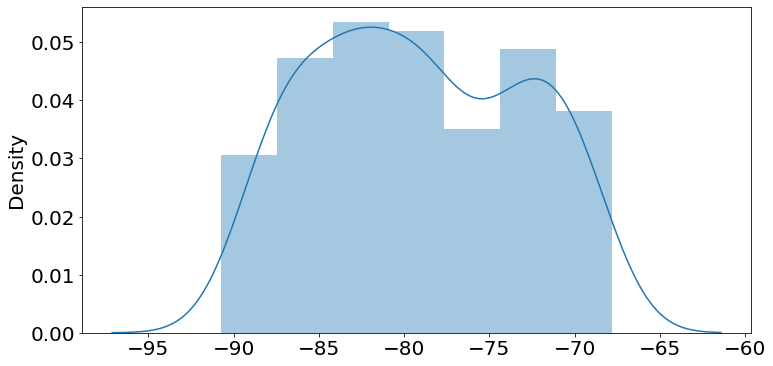

In [3]:
#load specific column of data
sigma_mu = coral_data['Coring uncertainty (m)']/2
nu_l = coral_data['Palaeowater depth min']
nu_u = coral_data['Palaeowater depth max']
omega = -coral_data['Corrected Depth Below Sea Level, mbsl DS (m)']#paleo RSL is represented by omega, which is the oppsite of corredted depth below sea-level 

#plot the first RSL model, you can change the index to see different RSL model
index = 0

random_sample_num = 200 #the number of samples draw from the data model

#try to visualize the first coral reef data
mu_1 = np.random.normal(0,sigma_mu.iloc[index],random_sample_num) #randomly draw samples from a coring uncertainty model, or measurement uncertainty model
nu_1 = np.random.uniform(nu_l.iloc[index],nu_u.iloc[index],random_sample_num) #randomly draw samples from a coral living depth model, or inferential uncertainty model
epsilon_1 = mu_1 + nu_1 #add two uncertainty model together
omega_1 = omega.iloc[index] 
y_1 = omega_1+epsilon_1 #add paleo RSL and two uncertainty together

sns.distplot(y_1);

You can see the probablity density function (PDF) above represents the vertical part of data level of RSL reconstruction by a coral reef record. And to reconstruct a complete story, we also need to know when this coral record formed ($t$), which can be found in columns `Calibrated 14C age (Cal yr BP)` or `U-Th age (BP)` depends on which Radiometric dating technique was used for that record. Like reconstructed RSL $y$, the age of record ($t$) is also subject to uncertainty $\delta$ which is commonly assumed to be normally distributed:

$$
\delta \sim N(0,\sigma_{\delta})
$$

Based on this, we can also generate a model for RSL age:

$$
\overline{t}_{i} = t_{i} + \delta_{i}
$$

where $\overline{t}$ is the central point estimate of the calibrated age and $t$ is the true age. Let's visulise the age model as well


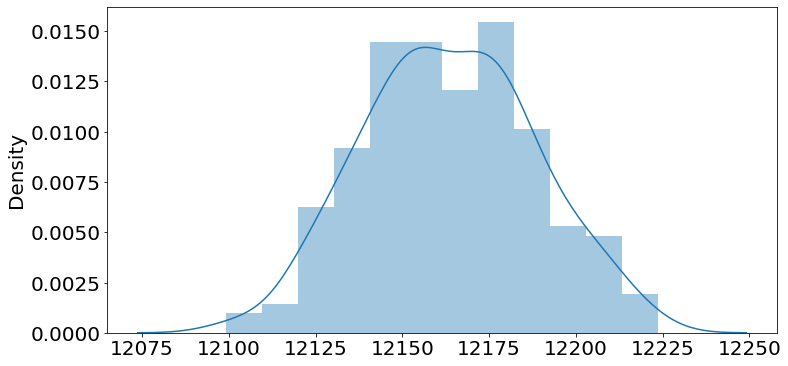

In [4]:
#load the data
radiocarbon_t = coral_data['Calibrated 14C age\n (Cal yr BP)']
radiocarbon_sigma = coral_data['±2s']/2
U_t = coral_data['U-Th age\n(BP)']
U_sigma = coral_data['±2s.1']/2
#a trick to combined radiocaron data and U-sereis data
radiocarbon_t[np.isnan(radiocarbon_t)] = 0
radiocarbon_sigma[np.isnan(radiocarbon_sigma)] = 0
U_t[np.isnan(U_t)] = 0
U_sigma[np.isnan(U_sigma)] = 0

#create age model
t_line = U_t + radiocarbon_t
t_sigma = U_sigma + radiocarbon_sigma

t_index = 0
t_line_i = t_line.iloc[t_index]
t_sigma_i = t_sigma.iloc[t_index]

sigma_delta = np.random.normal(0,t_sigma_i,random_sample_num)
t_i = t_line_i - sigma_delta

sns.distplot(t_i);

We can also plot the age model along with RSL model to get a temporal field of RSL change.

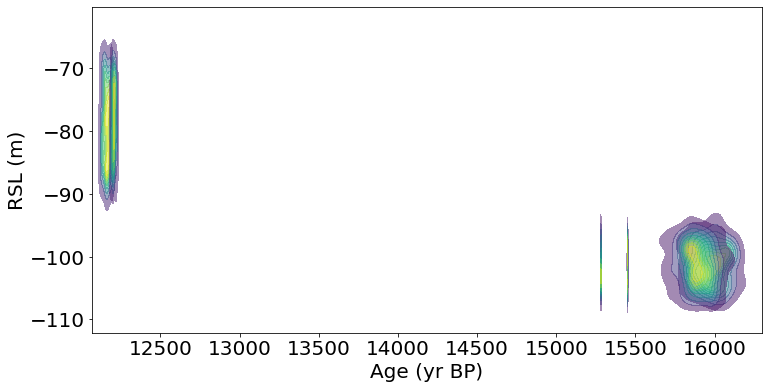

In [5]:
#visulize temporal variation of RSL data model

for i in range(len(coral_data)):
    t_index = i
    #calculate the age model
    sigma_delta = np.random.normal(0,t_sigma.iloc[t_index],random_sample_num)
    t_i = t_line.iloc[t_index] - sigma_delta

    #calculate the RSL model
    index = i
    mu_i = np.random.normal(0,sigma_mu.iloc[index],random_sample_num) 
    nu_i = np.random.uniform(nu_l.iloc[index],nu_u.iloc[index],random_sample_num) 
    epsilon_i = mu_i + nu_i
    omega_i = omega.iloc[index]
    y_i = omega_i+epsilon_i

    sns.kdeplot(t_i,y_i,fill=True,cmap='viridis',alpha=0.5)
plt.xlabel('Age (yr BP)')
plt.ylabel('RSL (m)');

Now we have a nice data level model for coral reef records from the Great Barrier Reef where each cloud shows the 2D PDF of reconstructed RSL! You will find some clouds are much smaller than the others, which is becuase the uncertainty by U-series dating technique is much lower than radiocarbon dating here. We can see that sea-level here rise 20-25 m between 15.5 ka to 12 ka, which covers a period of rapid global sea-level rise, called [Meltwater Pulse 1A](https://en.wikipedia.org/wiki/Meltwater_pulse_1A). 

#### 2.1.2 Alternative inferential uncertainty model
The data level model is very flexible, you can change $\mu$, $\nu$, $\delta$ to any other distributions based on your own assumption. For example, instead of assuming $\nu$ follows a uniform distribution, another common way to represent $\nu$ is:

$$
\nu_{2} \sim N((\tau_{l}+\tau_{u})/2,(\tau_{l}+\tau_{u})/4)
$$
which means $\nu$ follows a normal distribution with mean value in the middle of lower and upper limits with a quater of this range being used as the sigma for this distribution. Because a combination of two normally distributed variable will result in another normally distributed variable, therefore, some sea-level studies that assume a normally distributed RSL model will report a combined uncertainty by combining all uncertainty sources as:

$$
\epsilon_{2} = \mu+\nu_{2}\\
= N(0,\sigma_{\mu}) +N((\tau_{l}+\tau_{u})/2,(\tau_{l}+\tau_{u}/4)) \\
\sim N((\tau_{l}+\tau_{u})/2,\sqrt{\sigma_{\mu}^2+((\tau_{l}+\tau_{u})/4)^2})
$$

Let's visulize this model along with the model above:



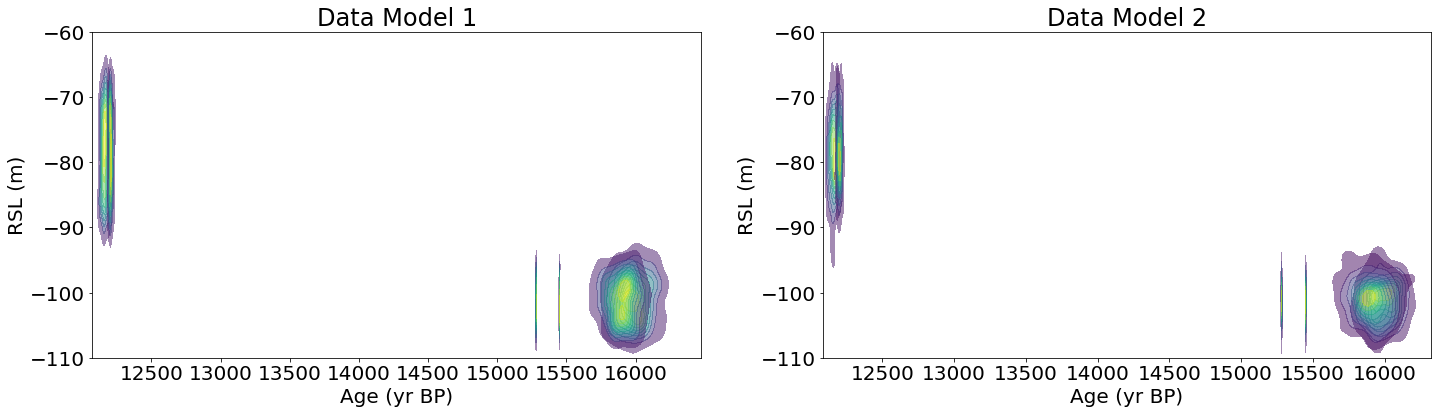

In [16]:
#visulize temporal variation of RSL data model

plt.figure(figsize=(24,6))
plt.subplot(121)
for i in range(len(coral_data)):
    t_index = i
    #calculate the age model
    sigma_delta = np.random.normal(0,t_sigma.iloc[t_index],random_sample_num)
    t_i = t_line.iloc[t_index] - sigma_delta

    #calculate the RSL model
    index = i
    mu_i = np.random.normal(0,sigma_mu.iloc[index],random_sample_num) 
    nu_i = np.random.uniform(nu_l.iloc[index],nu_u.iloc[index],random_sample_num) 
    epsilon_i = mu_i + nu_i
    omega_i = omega.iloc[index]
    y_i = omega_i+epsilon_i

    sns.kdeplot(t_i,y_i,fill=True,cmap='viridis',alpha=0.5)
plt.xlabel('Age (yr BP)')
plt.ylabel('RSL (m)');
plt.title('Data Model 1')
plt.ylim(-110,-60)
#----------Plot an alternative RSL model-----------------
plt.subplot(122)
for i in range(len(coral_data)):
    t_index = i
    #calculate the age model
    sigma_delta = np.random.normal(0,t_sigma.iloc[t_index],random_sample_num)
    t_i = t_line.iloc[t_index] - sigma_delta

    #calculate the RSL model
    index = i
    epsilon_sigma = np.sqrt(((nu_l.iloc[index]+nu_u.iloc[index])/4)**2+sigma_mu.iloc[index]**2) #combined sigma 
    epsilon_i = np.random.normal((nu_l.iloc[index]+nu_u.iloc[index])/2,epsilon_sigma,random_sample_num) 
    omega_i = omega.iloc[index]
    y_i = omega_i+epsilon_i

    sns.kdeplot(t_i,y_i,fill=True,cmap='viridis',alpha=0.5)
plt.title('Data Model 2')
plt.xlabel('Age (yr BP)')
plt.ylabel('RSL (m)')
plt.ylim(-110,-60);

By comparing these two models, you will find the reconstructed RSL for data model 2 is more centralized compared to data model 1, which is a result of assumed distribution type (uniform vs normal). These difference in data model will affect other components of sea-level hierarchical model and therefore the prediction results.

### 2.2 Process level

The process level is hierarchical level at which the variability of sea-levle change is modeled and in some cases, decomposed based on data model. The process level reflects our understandings of sea-level change processes. For simplicity, we introduce process level for modelling temporal sea-level processes here, but it can be easily extended to a higher dimension (e.g., spatio-temporal). Some typical methods used for represent process level of sea-level change are:

&#10148; **1. Any kind of hand-drawn curve:** Intuitively draw a curve to fit the observational data by hand. An example below from [Zong 2004](https://www.sciencedirect.com/science/article/pii/S1040618203001162?casa_token=hduIZdtNm-QAAAAA:hlPhRyw9NWqKl7pz3oakuR6K1JiVyAbhukAZshFbOMLGGg0jhAVuomutQdkDUOgolnSgfixwSQ) shows hand-drawn RSL curves for Southeast China during Holocene

<img width=800px src="Drawn_RSL.png"/>


&#10148; **2. Linear/polynomial model:** Assuming sea-level changes based on a certain kind of polynomial function (i.e., first-order polynomial equals temporally linear model, second-order polynomial can introduce a further parameter to control the rate of RSL change; acceleration/deceleration, etc...). An example below from [Lin et al., 2021](https://www.nature.com/articles/s41467-021-21990-y) assumes RSL change linearly during [Meltwater Pulse 1A](https://en.wikipedia.org/wiki/Meltwater_pulse_1A).

<img width=800px src="MWP_RSL.png"/>

&#10148; **3. Change-point model**: An extention of linear/polynomial model where a change-point model identifies points in the data where the rate of sea-level change can be significantly differnet before and after these points. An exmaple below from [Lambeck et al., 2014](https://www.pnas.org/doi/abs/10.1073/pnas.1411762111) uses a change point model approach to reconstruct global ice-equivalent sea-level from the 35 ka BP to present. 

<img width=800px src="ESL.png"/>

&#10148; **4. Gaussian Process model**: An nonparametric and Bayesian approach, to infer temporal variation of sea-level change based on covariance matrix estimated conditional upon the data. Compared to using other parametric models (e.g., polynomial, change-point model) to infer time series, GP time-series models have much more flexibility. An example below from [Tan et al., (2022)](https://www.sciencedirect.com/science/article/pii/S0277379123000434#fig3) shows relative sea-level change estimated based on a Gaussian Process modern conditioned on RSL data. 

<img width=400px src="GP_RSL.png"/>


&#10148; **5. Physical model**: RSL is predicted by the physical governing equations and specific physical parameters, such as ice history and Earth rheology for a glacial isostatic adjustment (GIA) model. An example below from [Simon et al., 2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB023693) shows different GIA model predictions in comparison to RSL data. 

<img width=800px src="Physical_RSL.png"/>

&#10148; **6. Mixed physical and statistical model or data assimilation**: This approach combined physical model with observational data (which can be represented by statistical models) to improve the accuracy and  reliability of predictions. An exmaple below from [Creel et al., 2022](https://www.sciencedirect.com/science/article/pii/S0277379122000531?casa_token=pY88KBJVoMgAAAAA:tlgDNf7iZ5hOKiPY9L5b5eA-Q_XMhlYtDSaBDjPZMdNjDPb1Kw3uaeRPp6ayyaijXn4EytwzOw#fig3) used an ensemble of GIA model to predict RSL at time and location where RSL data located at with different physical parameter combinations, they then update those physical model preidctions using a Guassian Process appraoch.

<img width=800px src="Norwary_RSL.png"/>

### 2.3 Parameter Level

The parameter level captures key attributes of the data and process levels through unobserved parameters, which can be physical or statistical parameters. With parameter level model, we can reflect our prior knowledge on the final prediction. For example, if we are using a Gaussian Process model to infer sea-level change rate, an important hyperparameter we need to define is length scale. If we have no idea whether sea-level change in your sites will be short-wavelength or long-wavelenth, we can set a non-informative prior to this hyperparameter. However, if we have some ideas about how sea-level may change here, commonly from physical insights, we can set the lengthscale to a certain plausible range. 


### 2.4 Illustrative example: New Jersey sea-level trend and rate modelling

To illustrate different process level models and see their difference in prediction performances, we will use real sea-level data from New Jersey ([Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740)), which contains 135 sea-level data points each with: reconstructed RSL, age, RSL reconstructeion uncertainty and age uncertainty. The data model used here assumes age and RSL are both distributed normally. Let's check the data first. Note, we will now start to use PaleoSTeHM module (PSTHM), which contains python functions to load/plot data, create/optimize statistical model.  

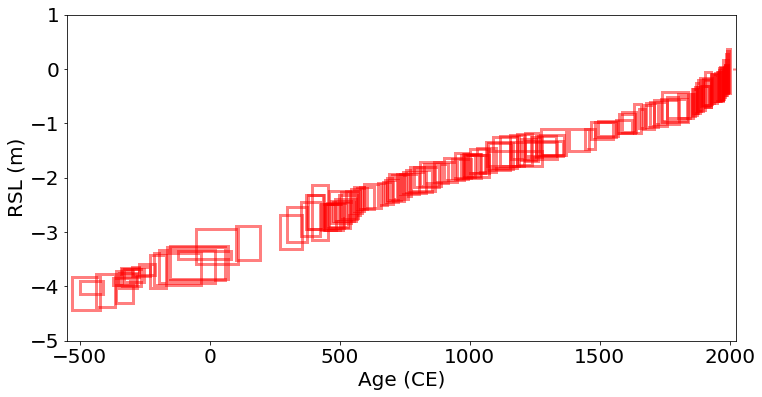

In [299]:
import sys
sys.path.append('../../Code')
import PSTHM 
import torch 

#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load_local_rsl_data('../../Data/NJ_CC.csv')
X,X_index = torch.sort(X)
y = y[X_index]
y_sigma = y_sigma[X_index]
x_sigma = x_sigma[X_index]
lon = torch.tensor(lon)[X_index]
lat = torch.tensor(lat)[X_index]
#visualize data
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

Remember that we assume both the RSL and age model to be normally distributed, as plotting their 2D distribution will be pretty noisy and hard to see, we plot 2-sigma uncertainty box instead. And we can start to test different process level models on it. And we will define model performances by mean squared error (MSE). 

#### 2.4.1 Hand-drawn curve

It seems to me that sea-level rose constantly from -500 to 500 CE and then accelerated to a higher rate between 500 and 1200 CE. After that sea-level rise rate slightly dropped until 1800 when sea-level started to rise much more rapidly. I can generate my intuitive curve by setting several points and link them. 

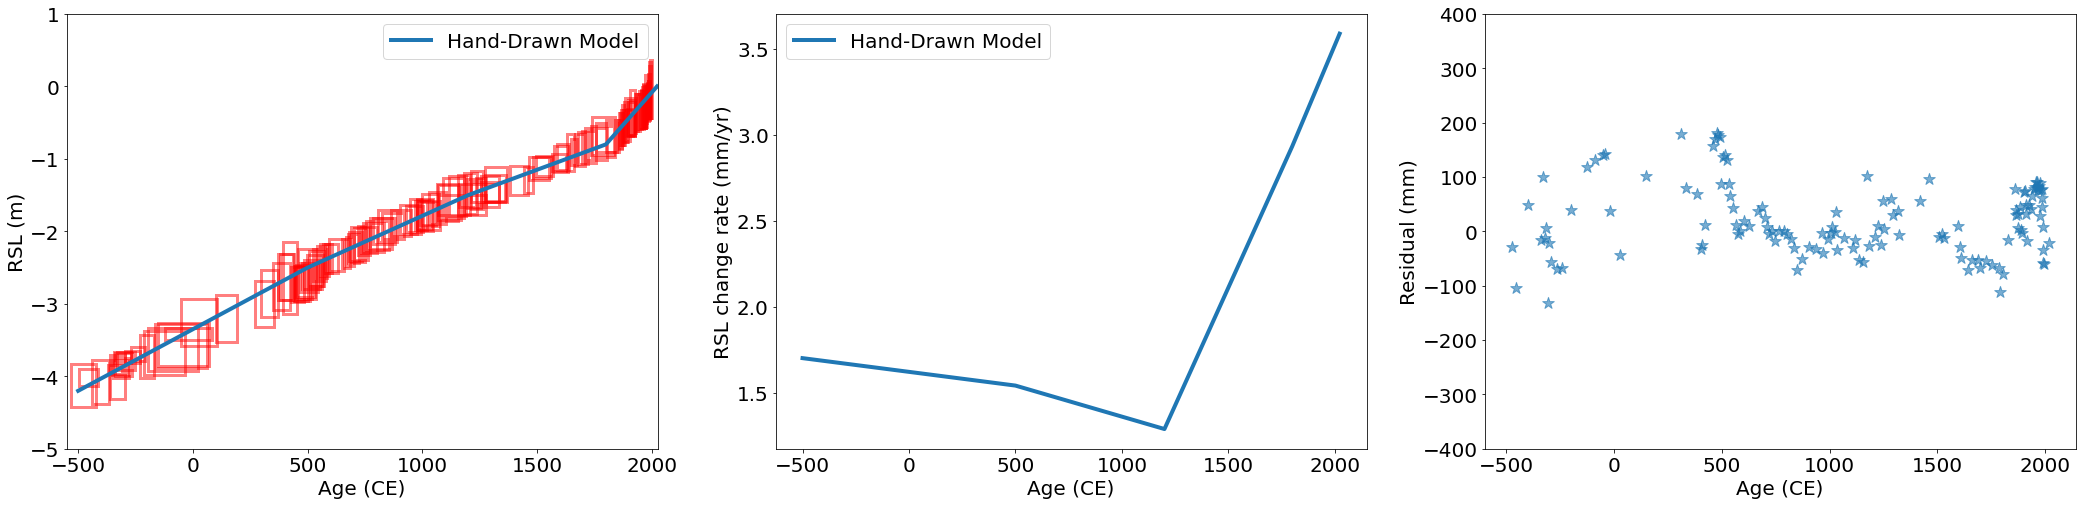

Hand-Drawn Model MSE: 0.0047


In [206]:
from scipy import interpolate
hand_model_x = [-500,500,1200,1800,2023]
hand_model_y = [-4.2,-2.5,-1.5,-0.8,0]

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(hand_model_x,hand_model_y,color='C0',linewidth=4,label='Hand-Drawn Model')
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(hand_model_x,np.gradient(hand_model_y,hand_model_x)*1000,color='C0',linewidth=4,label='Hand-Drawn Model')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_hand = interpolate.interp1d(hand_model_x,hand_model_y)
hand_prediction = f_hand(X)
plt.scatter(X,(hand_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.ylim(-400,400)
plt.show()
print('Hand-Drawn Model MSE: {:4.4f}'.format(PSTHM.cal_MSE(y.detach().numpy(),hand_prediction)));

We can see that the hand-drawn model is actually doing a great job, so for this problem, human intuition do provides some insights. And let's try the second methods.

#### 2.4.2 Linear/polynomial model

For a linear model, the process level of temporal sea-level change can be written as:
$$
f(\overline{t}_{i}) = \overline{t}_{i} \times a + b\\
$$
where $a$ is a sea-level rise rate coefficient, $b$ is a intercept coefficient, indicating sea-level when time is 0. Intergrate this parameter level model with data level model we get:

$$
y = f(\overline{t}_{i}) + \epsilon_{i}\\
  =  \overline{t}_{i} \times a + b + \epsilon_{i}\\
$$
where:
$$
\overline{t}_{i} = t_{i} +\delta_{i}
$$
And lastly, for a Bayesian model, very parameter is represented by a PDF instead of a single value, therefore, we need to define a prior distribution fo $a$ and $b$, which reflects our prior understandinging of them. And this is so called **parameter level model**. And for New Jersey data, I don't have too much information of how sea-level will change, so I assign non-informative prior to my parameter level:
$$
a \sim U(-0.01,0.01)\\
b \sim U(-5,5)
$$
which means I assume sea-level rise rate in this sites should be between -10 mm/yr and 10 mm/yr, and local sea-levle should sit between -5 m and 5 m, which are pretty safe assumptions. And now, we can write our hierarchical model together as:
$$
p(f,\epsilon,\delta, a, b|y) \propto p(y|f,\epsilon,\delta) \cdot p(f|a,b) \cdot p(\epsilon,\delta, a, b)
$$
Ok, now we have our first hierarchical model, we can now try to run it. Now we will start to use PaleoSTeHM API, which is built upon pyro, the code is fully commented, you can check the source code for more details.


  0%|          | 0/1500 [00:00<?, ?it/s]

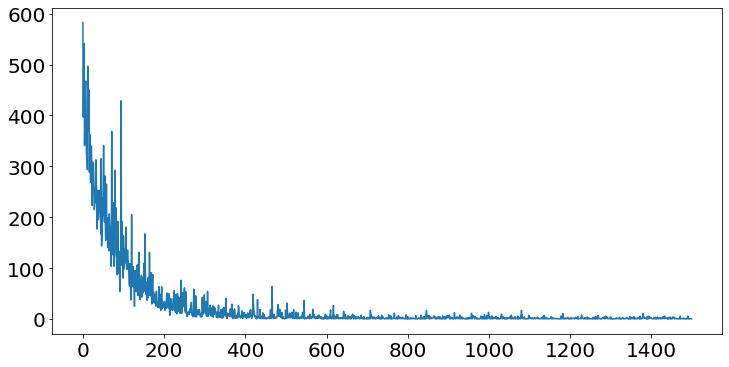

In [215]:
import pyro.distributions as dist

#------Define the process mdoel---------
linear_model = PSTHM.linear_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-5., 5.)
coefficient_prior = dist.Uniform(-0.01,0.01)

guide,losses = PSTHM.opti_pyro_mdoel(linear_model,test_X,y,x_sigma,y_sigma,intercept_prior,coefficient_prior,lr=0.01)
#-------Visualize the training loss---------
plt.plot(losses);

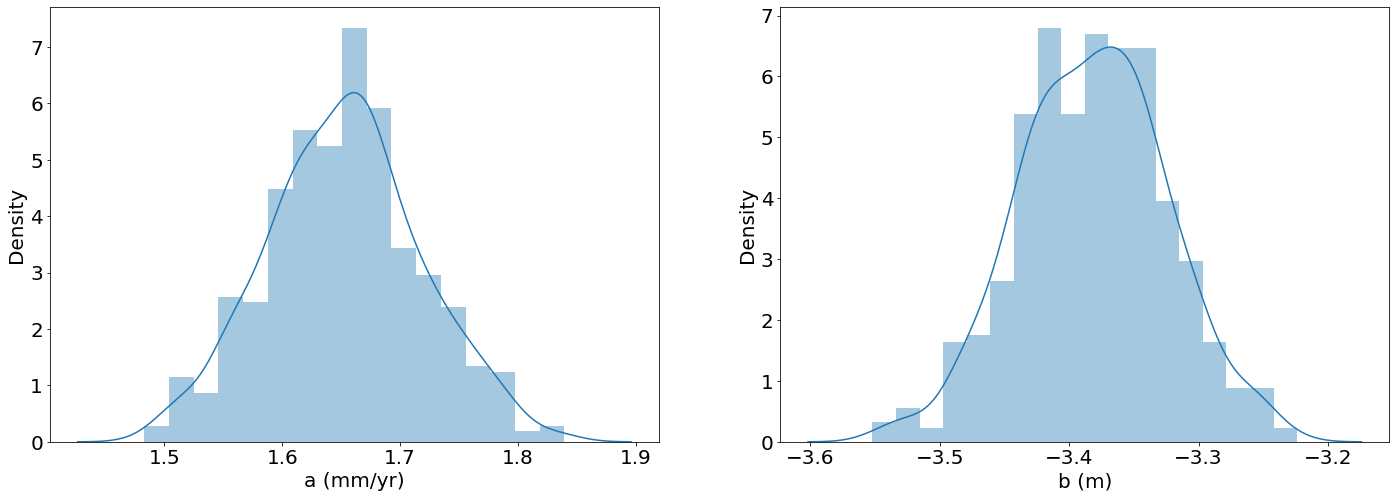

In [216]:
#estimate the posterior distribution of the model parameters from optimized model 
pred_x = torch.tensor([-500,2023])
sample_number = 500 #number of samples to draw from the posterior distribution
a_dis,b_dis,y_pred = torch.zeros(sample_number),torch.zeros(sample_number),torch.zeros(sample_number,len(pred_x))
for i in range(sample_number):
    test_b,test_a = guide().values()
    y_pred[i] = pred_x*test_a + test_b
    a_dis[i] = test_a
    b_dis[i] = test_b
y_pred = y_pred.detach().numpy()
a_dis = a_dis.detach().numpy()
b_dis = b_dis.detach().numpy()

#-------Visualize the posterior distribution of the model parameters---------
plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(a_dis*1000,axlabel='a (mm/yr)')
plt.subplot(122)
sns.distplot(b_dis,axlabel='b (m)');

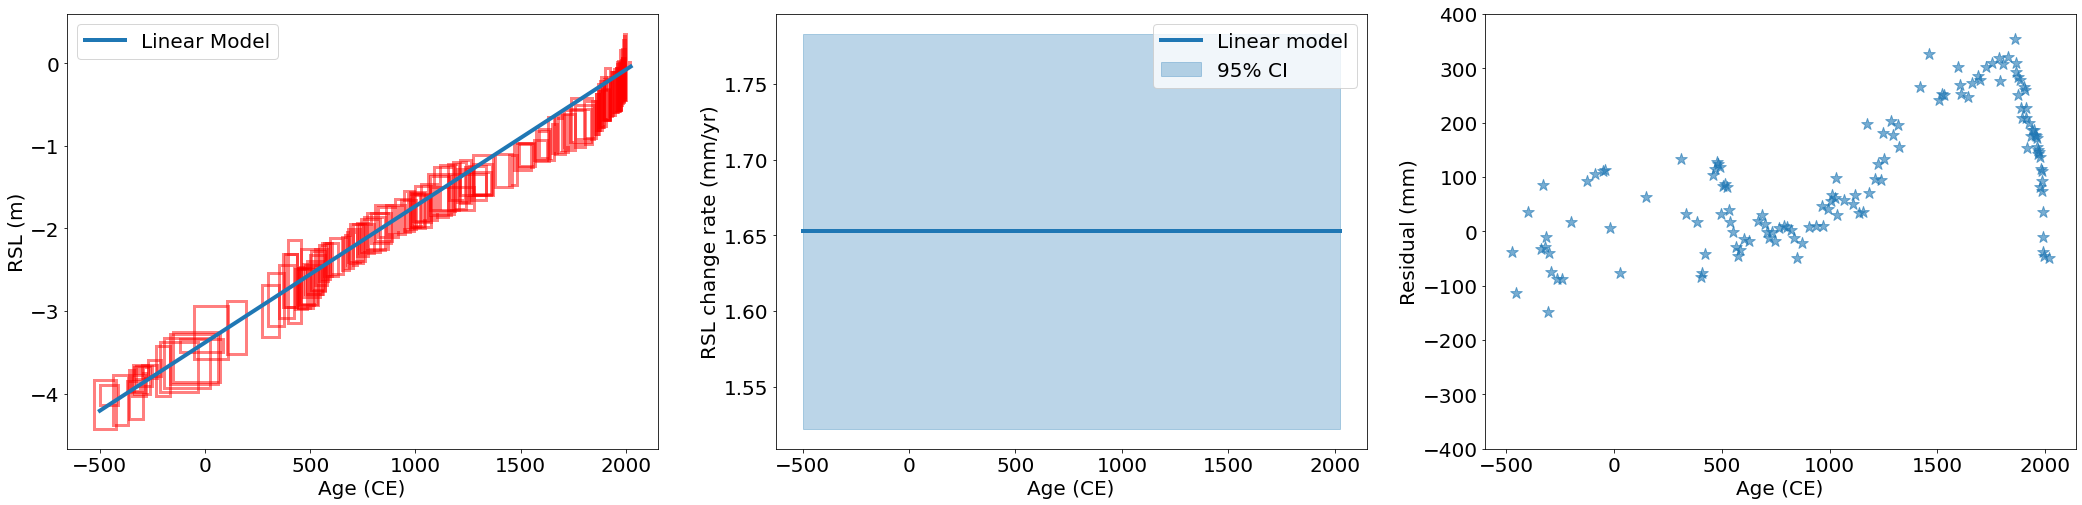

Linear Model MSE: 0.0241


In [228]:
a_mean,a_std = np.mean(a_dis),np.std(a_dis)
b_mean,b_std = np.mean(b_dis),np.std(b_dis)
mean_pred = np.mean(y_pred,axis=0)

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=4,label='Linear Model')
# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=4,label='Linear model')
plt.fill_between(pred_x,(a_mean-2*a_std)*1000,(a_mean+2*a_std)*1000,color='C0',alpha=0.3,label='95% CI')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_hand = interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_hand(X)
plt.scatter(X,(linear_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')

plt.ylabel('Residual (mm)')
plt.ylim(-400,400)
plt.show()
print('Linear Model MSE: {:4.4f}'.format(PSTHM.cal_MSE(y.detach().numpy(),linear_prediction)));


Now, you can see that instead of a single estimate of RSL trend and rate by a hand-drawn model (so-called the deterministic model, see more details in **Analysis choice** below), we are now able to infer posterior distributions of process model paraemters (sea-level rise rate and intercept coefficients) and of sea-level change trend and rate (so-called the Bayesian model). Therefore, we can start to quantify the uncetaitny of each parameter and prediction results.

However, the Bayesian method does not guarantee a better prediction performance as you can see here the MSE for this Bayesian model is actually higher than the hand-drawn model and the residual looks much more structed as well (a good performance should present residuals with no temporal structure with near stationary distribution). Instead of inference method (deterministic vs Bayesian), the process model choice usually has more impact on model performance, so make sure you have a think about which model fits the best for yoru own problem. 

From the MSE and residual structure above, we found that assuming a single sea-level rise rate in New Jersey is not a good choice. So instead of using a single RSL rate for the whole period, we can use one multiple rates for different periods, the change-point model.

#### 2.4.3 Change-point model

The change-point model is very popular process model to infer time series data because it can not only infer the rate of change in different periods of time but also when the rate is chaning, a very handy property for inferring abrupt change in sea level and climate science (see examples like [Caesar et al., 2021](https://www.nature.com/articles/s41561-021-00699-z)). This change-point model we used here is based on a [change-point modelling blog](https://www.niamhcahill.com/post/cptutorial/) by Niamh Cahill.  

The change point model separates the whole time period into seveal partitions where each partition has its own sea-level change rate. It is possible assign the number of change points (e.g., [Cahill et al., 2015](https://iopscience.iop.org/article/10.1088/1748-9326/10/8/084002)) or we can let the data itself to infer the number of change point (e.g., [Sambridge 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JB012901)). Here we will use the former model and so you can assign the number of change-point ($j$) you want to use, which can be expressed as:

$$
f(\overline{t}_{i}) = b + (\overline{t}_{i} -cp_{j})\times a_{j-1} \;\;\;\;\; if \;\; cp_{j}< \overline{t}_{i} \leq cp_{j+1} \\ 
f(\overline{t}_{i}) = b + (\overline{t}_{i} -cp_{j+1})\times a_{j} \;\;\;\;\; if \;\; \overline{t}_{i} > cp_{j+1} \\ 
$$

In [662]:
def change_point_model(X, y,x_sigma,y_sigma,n_cp,intercept_prior,coefficient_prior):
    '''
    A function to define a change-point model in pyro

    ------------Inputs--------------
    X: 2D torch tensor with shape (n_samples,n_features)
    y: 1D torch tensor with shape (n_samples)
    x_sigma: float, standard deviation of the error for age, which is obtained from the age data model
    y_sigma: float, standard deviation of the error for the RSL, which is obtained from the RSL datamodel
    n_cp: int, number of change-points
    intercept_prior: pyro distribution for the intercept coefficient
    coefficient_prior: pyro distribution for the slope coefficient

    '''
    # Define our intercept prior
    # intercept_prior = dist.Uniform(-5., 5.)
    b = pyro.sample("b", intercept_prior)
    beta_coef_list = torch.zeros(n_cp+1)
    cp_loc_list = torch.zeros(n_cp)
    #Define our coefficient prior
    cp_loc_prior = torch.linspace(X[:,0].min(),X[:,0].max(),n_cp+1)
    gap = cp_loc_prior[1]-cp_loc_prior[0]
    for i in range(n_cp+1):
        # coefficient_prior = dist.Uniform(-0.01, 0.01)
        beta_coef = pyro.sample(f"a_{i}", coefficient_prior)    
        beta_coef_list[i] = beta_coef
        if i<n_cp:
            cp_prior = dist.Uniform(cp_loc_prior[i]-gap,cp_loc_prior[i+1]+gap)
            cp_loc = pyro.sample(f"cp_{i}", cp_prior)
            cp_loc_list[i] = cp_loc
    # cp_loc_list,cp_sort_index = cp_loc_list.sort()
    # beta_coef_list = beta_coef_list[cp_sort_index]

    #generate random error for age
    x_noise = torch.normal(0, x_sigma)
    x_noisy = X[:, 0]+x_noise
    mean = torch.zeros(X.shape[0])
    last_intercept = b
    
    for i in range(n_cp+1):
        if i==0:
            start_age = X[:,0].min()
            start_idx = 0
            end_age = cp_loc_list[i]
            end_idx = torch.where(x_noisy<end_age)[0][-1]+1
            last_change_point = start_age
        elif i==n_cp:
            start_age = cp_loc_list[i-1]
            start_idx = torch.where(x_noisy>=start_age)[0][0]
            end_age = X[:,0].max()
            end_idx = X.shape[0]
        else:
            start_age = cp_loc_list[i-1]
            start_idx = torch.where(x_noisy>=start_age)[0][0]
            end_age = cp_loc_list[i]
            end_idx = torch.where(x_noisy<end_age)[0][-1]+1

        mean[start_idx:end_idx] = beta_coef_list[i] * (x_noisy[start_idx:end_idx]-last_change_point) + last_intercept
        last_intercept = beta_coef_list[i] * (end_age-last_change_point) + last_intercept
        last_change_point = end_age
    with pyro.plate("data", y.shape[0]):        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", dist.Normal(mean, y_sigma), obs=y)

  0%|          | 0/500 [00:00<?, ?it/s]

tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor(2017.)
tensor(-476.) tensor(3263.5000)
tensor(-1722.5000) tensor

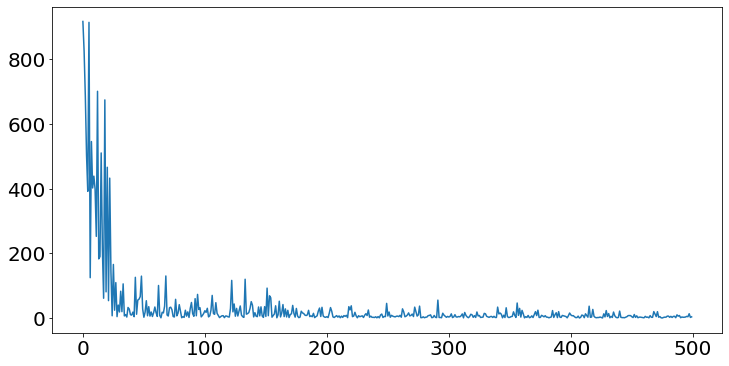

In [637]:
import pyro.distributions as dist

#------Define the process mdoel---------
change_point_model = change_point_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-6., -2.)
coefficient_prior = dist.Uniform(-0.01,0.01)

num_change_points = 2
guide,losses = PSTHM.opti_pyro_mdoel(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.01,number_of_steps=500)
#-------Visualize the training loss---------
plt.plot(losses);

In [630]:
def get_change_point_posterior(guide,sample_number):
    num_cp = int(list(guide().keys())[-1][list(guide().keys())[-1].index('_')+1:])
    output_dict = dict()
    output_dict['b'] = np.zeros(sample_number)
    output_dict['a'] = np.zeros([sample_number,num_cp+1])
    output_dict['cp'] = np.zeros([sample_number,num_cp])
    test_cp = []
    for i in range(num_cp):
        test_cp.append(guide.median()['cp_'+str(i)].detach().numpy())
    cp_index = np.argsort(test_cp)
    
    for i in range(sample_number):
        store_beta = []
        store_cp = []
        posterior_samples = guide()
        for i2 in range(num_cp+1):
            store_beta.append(posterior_samples['a_'+str(i2)].detach().numpy())
            if i2 < num_cp:
                store_cp.append(posterior_samples['cp_'+str(i2)].detach().numpy())
        output_dict['b'][i] = posterior_samples['b'].detach().numpy()
        output_dict['a'][i] = np.array(store_beta)
        output_dict['cp'][i] = np.array(store_cp)[cp_index]
    return output_dict

In [638]:
posterior = get_change_point_posterior(guide,1000)
forward_x = torch.arange(-550,2025,5)
change_point_pred = np.zeros([1000,len(forward_x)])
for i in range(1000):
    change_point_pred[i,:] = PSTHM.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],posterior['a'][i],posterior['b'][i])

change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)

Linear Model MSE: 0.0261


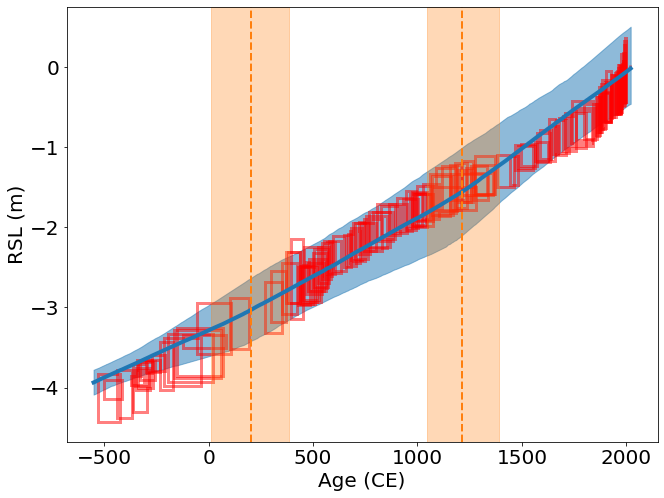

In [639]:

plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')

for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)


f_cp = interpolate.interp1d(forward_x,change_point_pred_50)
cp_prediction = f_cp(X)
print('Linear Model MSE: {:4.4f}'.format(PSTHM.cal_MSE(y.detach().numpy(),cp_prediction)));


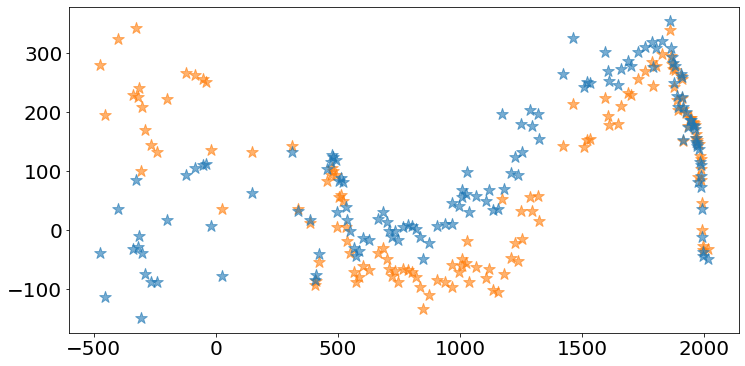

In [633]:
plt.scatter(X,(cp_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C1',alpha=0.6)
f_hand = interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_hand(X)
plt.scatter(X,(linear_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6)

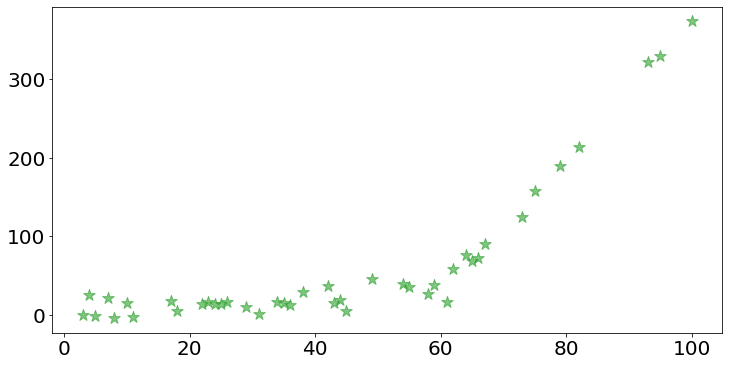

In [812]:
simu_x = np.arange(0,101,1)[np.sort(np.unique(np.random.randint(0,101,50)))]
index = simu_x<60
y = np.zeros(len(simu_x))
y[index] = simu_x[index]*0.5+2
y[~index] = (simu_x[~index]-60)*8.5 +(60*0.5+2)
y_sigma = 10
x_sigma = 1
y = y + np.random.normal(0,y_sigma,len(y))
plt.scatter(simu_x,y,s=150,marker='*',color='C2',alpha=0.6)

  0%|          | 0/1000 [00:00<?, ?it/s]

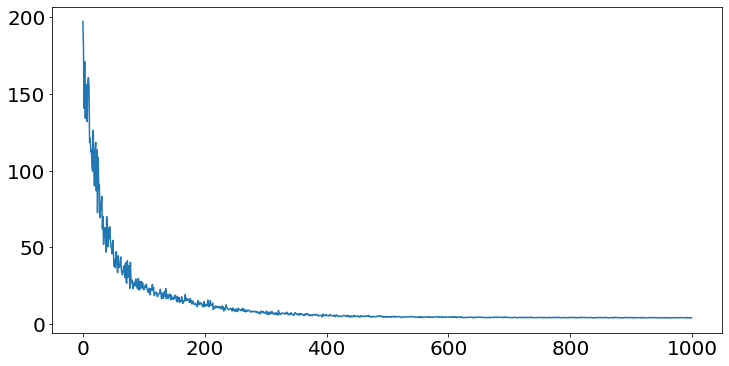

In [813]:
import pyro.distributions as dist

#------Define the process mdoel---------
change_point_model = change_point_model
test_X = torch.tensor(simu_x)[:,None] #convert X to a 2D array which is more common for pytorch models
y = torch.tensor(y)
#-------Define parameter model---------
intercept_prior = dist.Uniform(0.,50)
coefficient_prior = dist.Uniform(0,10)

num_change_points = 1
x_sigma = torch.ones(len(test_X))*x_sigma
y_sigma = torch.ones(len(test_X))*y_sigma
guide,losses = PSTHM.opti_pyro_mdoel(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.02,number_of_steps=1000)
#-------Visualize the training loss---------
plt.plot(losses);

In [814]:
guide.quantiles([0.025, 0.5, 0.975])

{'b': tensor([2.1067, 3.0552, 4.3915]),
 'a_0': tensor([0.5234, 0.5996, 0.6860]),
 'cp_0': tensor([60.6059, 61.4607, 62.3092]),
 'a_1': tensor([8.2316, 8.4806, 8.7000])}

In [815]:
posterior = get_change_point_posterior(guide,1000)
forward_x = torch.arange(0,100,1)
change_point_pred = np.zeros([1000,len(forward_x)])
for i in range(1000):
    change_point_pred[i,:] = PSTHM.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],posterior['a'][i],posterior['b'][i])

change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)

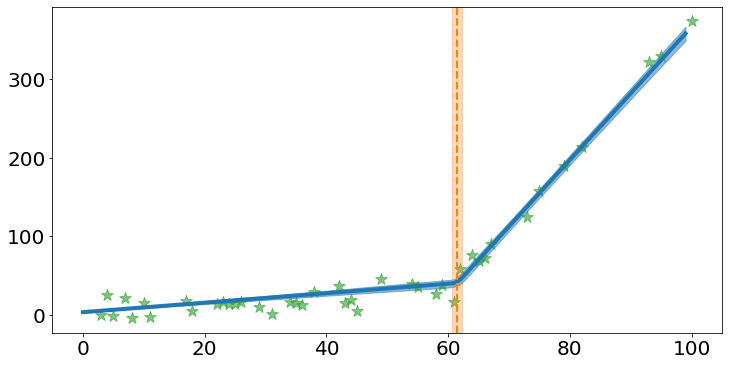

In [816]:
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')
plt.scatter(simu_x,y,s=150,marker='*',color='C2',alpha=0.6)
for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)



In [723]:
def change_point_model(X, y,x_sigma,y_sigma,n_cp,intercept_prior,coefficient_prior):
    '''
    A function to define a change-point model in pyro

    ------------Inputs--------------
    X: 2D torch tensor with shape (n_samples,n_features)
    y: 1D torch tensor with shape (n_samples)
    x_sigma: float, standard deviation of the error for age, which is obtained from the age data model
    y_sigma: float, standard deviation of the error for the RSL, which is obtained from the RSL datamodel
    n_cp: int, number of change-points
    intercept_prior: pyro distribution for the intercept coefficient
    coefficient_prior: pyro distribution for the slope coefficient

    '''
    # Define our intercept prior
    # intercept_prior = dist.Uniform(-5., 5.)
    b = pyro.sample("b", intercept_prior)
    beta_coef_list = torch.zeros(n_cp+1)
    cp_loc_list = torch.zeros(n_cp)
    #Define our coefficient prior
    cp_loc_prior = torch.linspace(X[:,0].min(),X[:,0].max(),n_cp+1)
    gap = cp_loc_prior[1]-cp_loc_prior[0]
    for i in range(n_cp+1):
        # coefficient_prior = dist.Uniform(-0.01, 0.01)
        beta_coef = pyro.sample(f"a_{i}", coefficient_prior)    
        beta_coef_list[i] = beta_coef
        if i<n_cp:
            cp_prior = dist.Uniform(cp_loc_prior[i],cp_loc_prior[i+1])
            cp_loc = pyro.sample(f"cp_{i}", cp_prior)
            cp_loc_list[i] = cp_loc
    # cp_loc_list,cp_sort_index = cp_loc_list.sort()
    # beta_coef_list = beta_coef_list[cp_sort_index]

    #generate random error for age
    x_noise = torch.normal(0, x_sigma)
    x_noisy = X[:, 0]+x_noise
    mean = torch.zeros(X.shape[0])
    last_intercept = b
    
    for i in range(n_cp+1):
        if i==0:
            start_age = X[:,0].min()
            start_idx = 0
            end_age = cp_loc_list[i]
            end_idx = torch.where(x_noisy<end_age)[0][-1]+1
            last_change_point = start_age
        elif i==n_cp:
            start_age = cp_loc_list[i-1]
            start_idx = torch.where(x_noisy>=start_age)[0][0]
            end_age = X[:,0].max()
            end_idx = X.shape[0]
        else:
            start_age = cp_loc_list[i-1]
            start_idx = torch.where(x_noisy>=start_age)[0][0]
            end_age = cp_loc_list[i]
            end_idx = torch.where(x_noisy<end_age)[0][-1]+1

        mean[start_idx:end_idx] = beta_coef_list[i] * (x_noisy[start_idx:end_idx]-last_change_point) + last_intercept
        last_intercept = beta_coef_list[i] * (end_age-last_change_point) + last_intercept
        last_change_point = end_age
    with pyro.plate("data", y.shape[0]):        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", dist.Normal(mean, y_sigma), obs=y)

## 3. Analysis choice 
